**Solution Summary**

My Solution: [discussion](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/324595)

I solved this task as a binary classification problem to predict whether or not each product was bought in the last week of `transactions_train.csv`. To create features, I used
the purchase data from the previous weeks.

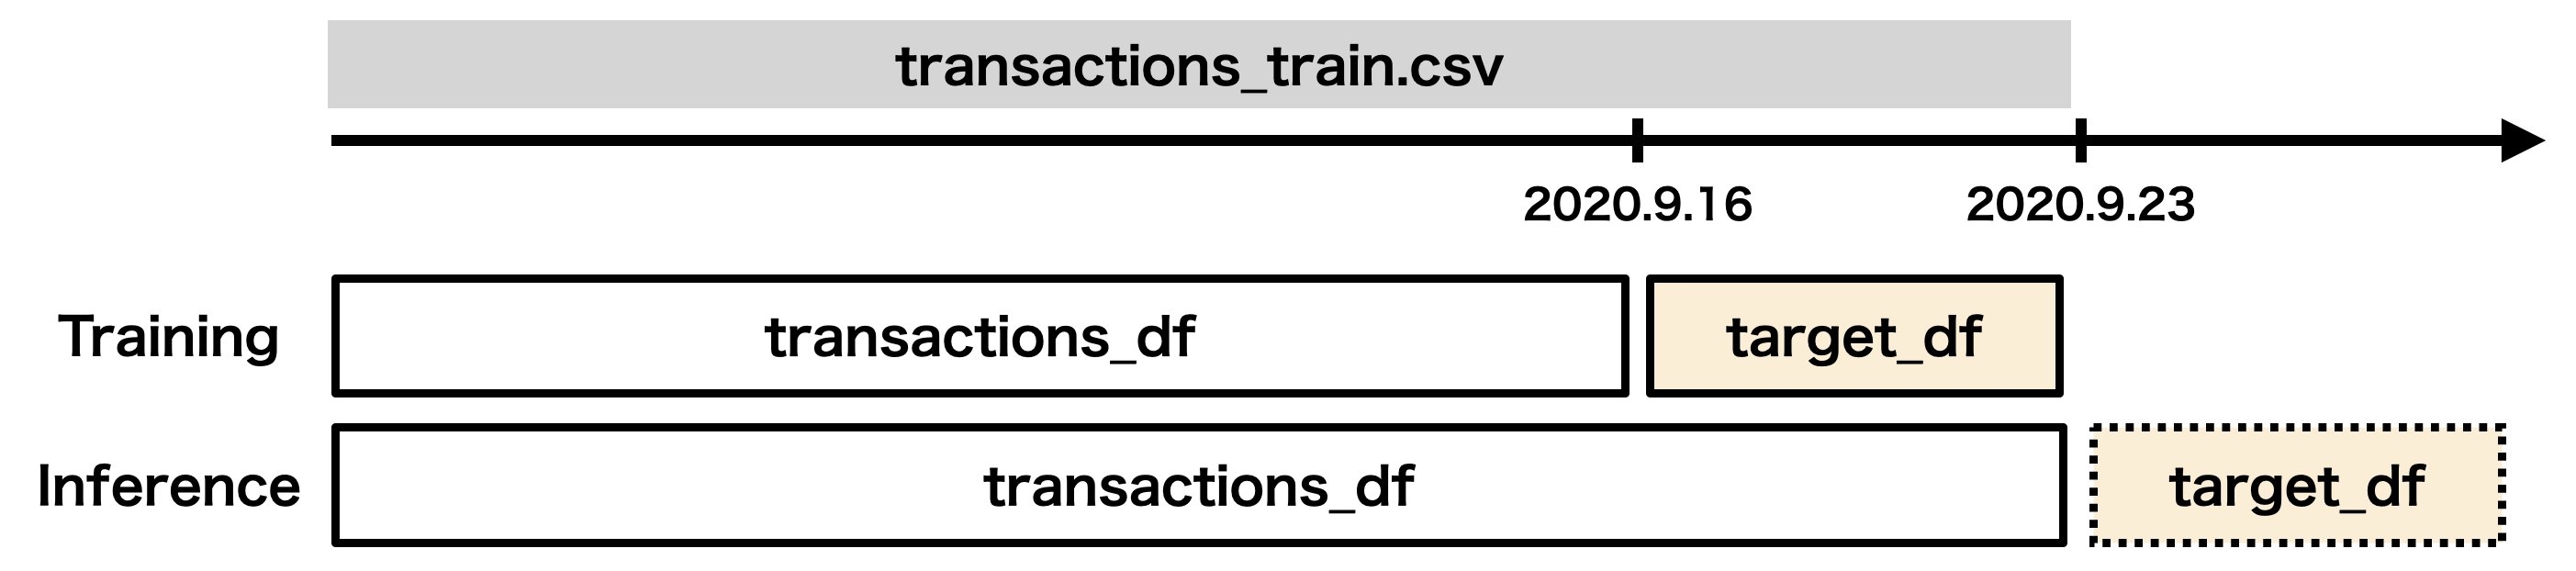

**about this format**

On both Kaggle and Colab, training and inference can be run on this single notebook!

1. Training
    
    Set `CFG.train = True` and run.

2. Inference

    Set `CFG.train = False` and run.

The duration of `transactions_df` and `target_df` is automatically changed by True/False of `CFG.train`.

In [ ]:
!nvidia-smi

Thu Aug 18 14:53:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Libraries

In [ ]:
# ====================================================
# import libraries
# ====================================================

import warnings
warnings.filterwarnings('ignore')

import json
import os
import numpy as np
import pandas as pd
import gc
import time
import torch
import random
import sys
from tqdm import tqdm
from pathlib import Path
import itertools
import collections
import joblib
from gensim.models import word2vec
import datetime
from datetime import timedelta
import hashlib
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from collections import Counter
from PIL import Image
from pathlib import Path
import pickle
from contextlib import contextmanager
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
import lightgbm as lgb
import typing as tp
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import torch
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter

tqdm.pandas()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(f'Using device: {device}')

Using device: cuda


# Config

In [ ]:
# ==============================================
#  Config
# ==============================================

class CFG:
    colab = "google.colab" in sys.modules
    exp = "120"
    train = True
    submit = False
    api_path = '/content/drive/My Drive/kaggle.json'
    seed = 42
    used_fold = [0,1,2,3,4]
    fold = 5
    part = 0
    target = "target"
    
val_start_date = '2020-09-16'

In [ ]:
# ==============================================
#  Catboost parameters
# ==============================================

DROP_COLS = [
    "customer_id",
    "article_id",
    #"product_code",
    #"product_type_no",
    #"graphical_appearance_no",
    #"colour_group_code",
    #"index_group_no",
    #"section_no",
    #"garment_group_no",
]


CATEGORICAL_COLS = [
    # ---------------------------------------------------------
    # Article features
    # ---------------------------------------------------------
    #"product_code",
    #"product_type_no",
    #"graphical_appearance_no",
    #"colour_group_code",
    #"index_group_no",
    #"section_no",
    #"garment_group_no",
    # ---------------------------------------------------------
    # Customer features
    # ---------------------------------------------------------
    #"FN",
    #"Active",
    #"club_member_status",
    #"fashion_news_frequency",
    #"postal_code",
]

PARAMS = {
    'loss_function': 'Logloss',
    'learning_rate': 0.02,
    'max_depth': 6,
    'random_state': CFG.seed,
    'thread_count': 2,
    'task_type': 'GPU',
    'scale_pos_weight': 100,
    'num_boost_round': 15000,
}

In [ ]:
if CFG.colab:
    print("==============================================")
    print("This environment is Google Colab")
    print("==============================================")

    # Google Drive
    from google.colab import drive, files
    drive.mount('/content/drive')
    %cd "drive/My Drive/h-and-m/"

    # Kaggle API
    f = open(CFG.api_path, 'r')
    json_data = json.load(f) 
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]

    # Directory Setting
    if not os.path.exists(f"output/exp{CFG.exp}/"):
        os.makedirs(f"output/exp{CFG.exp}/")

    DATA_DIR = "input/"
    OUTPUT_DIR = f"output/exp{CFG.exp}/"
    MODEL_DIR = OUTPUT_DIR

    if not os.path.exists(OUTPUT_DIR + f"exp{CFG.exp}/"):
        os.makedirs(OUTPUT_DIR + f"exp{CFG.exp}/")
    
    # Data Loading
    if not os.path.isfile(os.path.join(DATA_DIR, "transactions_train.csv.zip")):
        !kaggle competitions download -c h-and-m-personalized-fashion-recommendations -p $DATA_DIR
    
    # Libraries
    !pip install -q catboost
    !pip install -q transformers
    
else:
    print("==============================================")
    print(" This environment is Kaggle Notebook")
    print("==============================================")

    # Directory Setting
    OUTPUT_DIR = "./"
    DATA_DIR = "../input/h-and-m-personalized-fashion-recommendations/"

# ====================================================
# import libraries2
# ====================================================

from catboost import CatBoost, Pool
import transformers

# Helper Functions

In [ ]:
def get_swap_dict(d):
    return {v: k for k, v in d.items()}

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Memory usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
def compare_vectors(v1, v2):
    intersection = len(set(v1) & set(v2))
    denominator = np.sqrt(len(v1) * len(v2))
    return intersection / denominator

def flatten(x):
    return [e for i in x for e in i]

In [ ]:
@contextmanager
def timer(name: str):
    t0 = time.time()
    print(f"[{name}] start")
    yield
    msg = f"[{name}] done in {time.time() - t0:.0f} s"
    print(msg)

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def hashfxn(x):
    return int(hashlib.md5(str(x).encode()).hexdigest(), 16)

seed_everything(CFG.seed)

In [ ]:
def init_logger(log_file=OUTPUT_DIR+'train.log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    logger.hasHandlers()
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

In [ ]:
# ====================================================
#  Calculate MAP@12
# ====================================================
# Reference: https://www.kaggle.com/kaerunantoka/h-m-how-to-calculate-map-12

def apk(actual, predicted, k=12):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=12):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [ ]:
ARTICLE_FEATURES = ["product_code", "product_type_no", "graphical_appearance_no", "colour_group_code", "index_group_no", "section_no", "garment_group_no"]

# Data Loading

In [ ]:
with timer("Data Loading"):
    transactions_df = reduce_mem_usage(pd.read_pickle(DATA_DIR + "transactions.pkl"))
    articles_df = reduce_mem_usage(pd.read_pickle(DATA_DIR + "articles.pkl"))
    customers_df = reduce_mem_usage(pd.read_pickle(DATA_DIR + "customers.pkl"))
    sub_df = reduce_mem_usage(pd.read_pickle(DATA_DIR + "sub.pkl"))

[Data Loading] start
Memory usage decreased to 576.00 Mb (0.0% reduction)
Memory usage decreased to  3.52 Mb (0.0% reduction)
Memory usage decreased to 17.01 Mb (0.0% reduction)
Memory usage decreased to  5.23 Mb (0.0% reduction)
[Data Loading] done in 5 s


In [ ]:
if CFG.train:
    target_df = transactions_df.query(f"t_dat >= '{val_start_date}'").reset_index(drop=True)
    transactions_df = transactions_df.query(f"t_dat < '{val_start_date}'").reset_index(drop=True)
else:
    target_df = sub_df.copy()
    del sub_df
    gc.collect()

display(transactions_df.head(5))
display(target_df.head(5))

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,2,40179,0.050842,2
1,2018-09-20,2,10520,0.030487,2
2,2018-09-20,7,6387,0.015236,2
3,2018-09-20,7,46304,0.016937,2
4,2018-09-20,7,46305,0.016937,2


,t_dat,customer_id,article_id,price,sales_channel_id
0,2020-09-16,330,76695,0.048431,2
1,2020-09-16,330,103575,0.032288,2
2,2020-09-16,330,100334,0.056519,2
3,2020-09-16,349,420,0.033875,1
4,2020-09-16,349,14240,0.013542,1


In [ ]:
def original_df_features(original_df):
    original_df["week"] = ((original_df.t_dat.max() - original_df.t_dat).dt.days // 7).astype("int8")
    original_df["day"] = ((original_df.t_dat.max() - original_df.t_dat).dt.days).astype("int16")
    original_df["sales_channel_id"] = original_df["sales_channel_id"]-1
    return original_df

In [ ]:
def make_df(original_df):

    # ==========================================================================
    #  Step1: Top300 popular items
    # ==========================================================================

    tmp1 = pd.DataFrame(target_df["customer_id"].unique()).rename(columns={0: "customer_id"})

    # For memory measures, the customer is divided into 14 parts when inferring.
    if not(CFG.train):
        a = 100000*CFG.part
        b = 100000*(CFG.part+1)
        tmp1 = tmp1.query(f"{a}<=customer_id<{b}").reset_index(drop=True)

    if CFG.train:
        tmp2 = pd.DataFrame(target_df.groupby(["article_id"])["customer_id"].nunique().sort_values(ascending=False).index[:300])
    else:
        tmp2 = pd.DataFrame(original_df.query(f"t_dat >= '{val_start_date}'").groupby(["article_id"])["customer_id"].nunique().sort_values(ascending=False).index[:300])

    tmp1["tmp"] = 0
    tmp2["tmp"] = 0

    df = pd.merge(tmp1, tmp2, on="tmp", how="outer")

    # ==========================================================================
    #  Step2: items with the same product code as previously purchased items
    # ==========================================================================

    tmp3 = original_df[["article_id", "customer_id"]].reset_index(drop=True)
    tmp3 = tmp3[tmp3["customer_id"].isin(tmp1["customer_id"])].reset_index(drop=True)
    tmp3 = pd.merge(tmp3, articles_df[["article_id", "product_code"]], on="article_id", how="left")
    tmp3 = tmp3.drop_duplicates(["customer_id", "product_code"])[["customer_id", "product_code"]].reset_index(drop=True)

    tmp4 = articles_df[articles_df["product_code"].isin(tmp3["product_code"].unique())][["article_id", "product_code"]].reset_index(drop=True)
    tmp4 = pd.merge(tmp3, tmp4, on="product_code", how="outer")[["customer_id", "article_id"]]

    if CFG.train:
        tmp4 = tmp4[tmp4["article_id"].isin(target_df.groupby(["article_id"])["customer_id"].nunique().sort_values(ascending=False).index)].reset_index(drop=True)
    else:
        tmp4 = tmp4[tmp4["article_id"].isin(original_df.query(f"t_dat >= '{val_start_date}'").groupby(["article_id"])["customer_id"].nunique().sort_values(ascending=False).index)].reset_index(drop=True)

    df = pd.concat([df, tmp4]).drop_duplicates(["customer_id", "article_id"], keep="last").reset_index(drop=True)

    # ==========================================================================
    #  Make label
    # ==========================================================================
    if CFG.train:
        tmp5 = target_df.drop_duplicates(["customer_id", "article_id"])[["article_id", "customer_id"]].reset_index(drop=True)
        tmp5["target"] = 1

        df = pd.merge(df, tmp5, on=["customer_id", "article_id"], how="left")
        df["target"] = df["target"].fillna(0).astype("int8")

        del tmp5

    del tmp1, tmp2, tmp3, tmp4, df["tmp"]
    gc.collect()

    return df

In [ ]:
def add_article_information(df):
    df = pd.merge(df, articles_df[["article_id"]+ARTICLE_FEATURES], on="article_id", how="left")
    return df

In [ ]:
def add_customer_information(df):
    df = pd.merge(df, customers_df[["customer_id", "age"]], on="customer_id", how="left")
    return df

In [ ]:
def cf_features(original_df, df):
    """
    cf_score.pickle is made by this code.

    Reference: https://www.kaggle.com/code/poteman/hm-item-cf
    ----------------------------------------------------
    def get_sim_item(df, user_col, item_col, use_iif=False):  
        user_item_ = df.groupby(user_col)[item_col].agg(set).reset_index()  
        user_item_dict = dict(zip(user_item_[user_col], user_item_[item_col]))

        del user_item_
        gc.collect()
        
        sim_item = {}
        item_cnt = defaultdict(int)  
        for user, items in tqdm(user_item_dict.items()):  
            for i in items:
                item_cnt[i] += 1
                sim_item.setdefault(i, {})
                for relate_item in items:  
                    if not relate_item in popular_item:  
                        continue  
                    sim_item[i].setdefault(relate_item, 0)  
                    if not use_iif:  
                        sim_item[i][relate_item] += 1  
                    else:  
                        sim_item[i][relate_item] += 1 / math.log(1 + len(items))  
        sim_item_corr = sim_item.copy()  
        for i, related_items in tqdm(sim_item.items()):  
            for j, cij in related_items.items():  
                sim_item_corr[i][j] = cij/math.sqrt(item_cnt[i]*item_cnt[j])  
    
        return sim_item_corr, user_item_dict

    def recommend(sim_item_corr, user_item_dict, user_id):  
        rank = {}
        interacted_items = user_item_dict[user_id]  
        for i in interacted_items:
            for j, wij in sorted(sim_item_corr[i].items(), key=lambda d: d[1], reverse=True): 
                rank.setdefault(j, 0)  
                rank[j] += wij  
        return sorted(rank.items(), key=lambda d: d[1], reverse=True)
    
    popular_item = target_df.groupby(["article_id"])["customer_id"].nunique().sort_values(ascending=False).index[:300]
    item_sim_list, user_item = get_sim_item(transactions_df, user_col = 'customer_id', item_col = 'article_id', use_iif=True)

    for i in range(14):
        a = 100000*i
        b = 100000*(i+1)
        new_df = []
        for c in tqdm(transactions_df.query(f"{a}<=customer_id<{b}")["customer_id"].unique()):
            tmp = pd.DataFrame(recommend(item_sim_list, user_item, c))
            tmp["customer_id"] = c
            new_df.append(tmp)
        new_df = pd.concat(new_df).reset_index(drop=True)
        new_df = new_df.rename(columns={0: "article_id", 1: "cf_score"})
        with open(DATA_DIR + f"cf_score_test{i}.pickle", mode="wb") as f:
            pickle.dump(new_df, f, protocol=4)
    ----------------------------------------------------
    """
    for feature in ["article_id"]+ARTICLE_FEATURES:

        if CFG.train:
            with open(DATA_DIR + f"cf_score_{feature}.pickle", 'rb') as f:
                cf_score_df = pickle.load(f)
        else:
            with open(DATA_DIR + f"cf_score_{feature}_test{CFG.part}.pickle", 'rb') as f:
                cf_score_df = pickle.load(f)
        
        df = pd.merge(df, cf_score_df, on=[feature, "customer_id"], how="left")
        df[f"cf_score_{feature}"] = df[f"cf_score_{feature}"].astype("float16")
        
        del cf_score_df
        gc.collect()
    
    if CFG.train:
        with open(DATA_DIR + f"cf_score_article_with_channel.pickle", 'rb') as f:
            cf_score_df = pickle.load(f)
    else:
        with open(DATA_DIR + f"cf_score_article_with_channel_test{CFG.part}.pickle", 'rb') as f:
            cf_score_df = pickle.load(f)
    
    cf_score_df["sales_channel_id"] = cf_score_df["article_id"].apply(lambda x: int(x[-1]))
    cf_score_df["article_id"] = cf_score_df["article_id"].apply(lambda x: int(x[:-2]))

    tmp1 = cf_score_df.pivot_table(values=['cf_score_article_with_channel'], index=['customer_id', 'article_id'], columns=['sales_channel_id'], aggfunc='sum').reset_index()
    tmp1.columns = ["customer_id", "article_id", "cf_score_article_offline", "cf_score_article_online"]
    tmp1 = tmp1.fillna(0)

    tmp2 = cf_score_df.groupby(["customer_id", "article_id"])["cf_score_article_with_channel"].agg("sum").reset_index()

    df = pd.merge(df, tmp1, on=["article_id", "customer_id"], how="left")
    df = pd.merge(df, tmp2, on=["article_id", "customer_id"], how="left")

    df["cf_score_article_with_channel"] = df["cf_score_article_with_channel"].astype("float16")
    df["cf_score_article_offline"] = df["cf_score_article_offline"].astype("float16")
    df["cf_score_article_online"] = df["cf_score_article_online"].astype("float16")
    
    return df

In [ ]:
def cf_features2(original_df, df):
    """
    cf_score.pickle is made by this code.

    Reference: https://www.kaggle.com/code/poteman/hm-item-cf
    ----------------------------------------------------
    def get_sim_item2(df, user_col, item_col, use_iif=False):  
        user_item_ = df.groupby(user_col)[item_col].agg(set).reset_index()  
        user_item_dict = dict(zip(user_item_[user_col], user_item_[item_col]))

        del user_item_
        gc.collect()
        
        sim_item = {}
        item_cnt = defaultdict(int)  
        for user, items in tqdm(user_item_dict.items()):  
            for i in items:
                item_cnt[i] += 1
                sim_item.setdefault(i, {})
                for relate_item in items:  
                    if not relate_item in popular_item:  
                        continue  
                    sim_item[i].setdefault(relate_item, 0)  
                    if not use_iif:  
                        sim_item[i][relate_item] += 1  
                    else:  
                        sim_item[i][relate_item] += 1 / math.log(1 + len(items))  
        sim_item_corr = sim_item.copy()  
        for i, related_items in tqdm(sim_item.items()):  
            for j, cij in related_items.items():  
                sim_item_corr[i][j] = cij/item_cnt[i]  
    
        return sim_item_corr, user_item_dict

    def recommend(sim_item_corr, user_item_dict, user_id):  
        rank = {}
        interacted_items = user_item_dict[user_id]  
        for i in interacted_items:
            for j, wij in sorted(sim_item_corr[i].items(), key=lambda d: d[1], reverse=True): 
                rank.setdefault(j, 0)  
                rank[j] += wij  
        return sorted(rank.items(), key=lambda d: d[1], reverse=True)
    
    popular_item = target_df.groupby(["article_id"])["customer_id"].nunique().sort_values(ascending=False).index[:300]
    item_sim_list, user_item = get_sim_item2(transactions_df, user_col = 'customer_id', item_col = 'article_id', use_iif=False)

    for i in range(14):
        a = 100000*i
        b = 100000*(i+1)
        new_df = []
        for c in tqdm(transactions_df.query(f"{a}<=customer_id<{b}")["customer_id"].unique()):
            tmp = pd.DataFrame(recommend(item_sim_list, user_item, c))
            tmp["customer_id"] = c
            new_df.append(tmp)
        new_df = pd.concat(new_df).reset_index(drop=True)
        new_df = new_df.rename(columns={0: "article_id", 1: "cf_score"})
        with open(DATA_DIR + f"cf_score_test{i}.pickle", mode="wb") as f:
            pickle.dump(new_df, f, protocol=4)
    ----------------------------------------------------
    """

    if CFG.train:
        with open(DATA_DIR + "cf_score_v2.pickle", 'rb') as f:
            cf_score_df = pickle.load(f)
    else:
        with open(DATA_DIR + f"cf_score_v2_test{CFG.part}.pickle", 'rb') as f:
            cf_score_df = pickle.load(f)
    
    cf_score_df = cf_score_df.rename(columns={"cf_score": "cf_score2"})
    
    df = pd.merge(df, cf_score_df, on=["article_id", "customer_id"], how="left")
    df["cf_score2"] = df["cf_score2"].astype("float16")
    
    del cf_score_df
    gc.collect()
    
    return df

In [ ]:
def cf_features3(original_df, df):
    """
    cf_score.pickle is made by this code.

    Reference: https://www.kaggle.com/code/poteman/hm-item-cf
    ----------------------------------------------------
    def get_sim_item3(df, user_col, item_col, use_iif=False):  
        user_item_ = df.groupby(user_col)[item_col].agg(set).reset_index()  
        user_item_dict = dict(zip(user_item_[user_col], user_item_[item_col]))

        del user_item_
        gc.collect()
        
        sim_item = {}
        item_cnt = defaultdict(int)  
        for user, items in tqdm(user_item_dict.items()):  
            for i in items:
                item_cnt[i] += 1
                sim_item.setdefault(i, {})
                for relate_item in items:  
                    if not relate_item in popular_item:  
                        continue  
                    sim_item[i].setdefault(relate_item, 0)  
                    if not use_iif:  
                        sim_item[i][relate_item] += 1  
                    else:  
                        sim_item[i][relate_item] += 1 / math.log(1 + len(items))  
        sim_item_corr = sim_item.copy()  
        for i, related_items in tqdm(sim_item.items()):  
            for j, cij in related_items.items():  
                sim_item_corr[i][j] = cij/item_cnt[j]
    
        return sim_item_corr, user_item_dict

    def recommend(sim_item_corr, user_item_dict, user_id):  
        rank = {}
        interacted_items = user_item_dict[user_id]  
        for i in interacted_items:
            for j, wij in sorted(sim_item_corr[i].items(), key=lambda d: d[1], reverse=True): 
                rank.setdefault(j, 0)  
                rank[j] += wij  
        return sorted(rank.items(), key=lambda d: d[1], reverse=True)
    
    popular_item = target_df.groupby(["article_id"])["customer_id"].nunique().sort_values(ascending=False).index[:300]
    item_sim_list, user_item = get_sim_item2(transactions_df, user_col = 'customer_id', item_col = 'article_id', use_iif=False)

    for i in range(14):
        a = 100000*i
        b = 100000*(i+1)
        new_df = []
        for c in tqdm(transactions_df.query(f"{a}<=customer_id<{b}")["customer_id"].unique()):
            tmp = pd.DataFrame(recommend(item_sim_list, user_item, c))
            tmp["customer_id"] = c
            new_df.append(tmp)
        new_df = pd.concat(new_df).reset_index(drop=True)
        new_df = new_df.rename(columns={0: "article_id", 1: "cf_score"})
        with open(DATA_DIR + f"cf_score_test{i}.pickle", mode="wb") as f:
            pickle.dump(new_df, f, protocol=4)
    ----------------------------------------------------
    """

    if CFG.train:
        with open(DATA_DIR + "cf_score_v3.pickle", 'rb') as f:
            cf_score_df = pickle.load(f)
    else:
        with open(DATA_DIR + f"cf_score_v3_test{CFG.part}.pickle", 'rb') as f:
            cf_score_df = pickle.load(f)
    
    cf_score_df = cf_score_df.rename(columns={"cf_score": "cf_score3"})
    
    df = pd.merge(df, cf_score_df, on=["article_id", "customer_id"], how="left")
    df["cf_score3"] = df["cf_score3"].astype("float16")
    
    del cf_score_df
    gc.collect()
    
    return df

In [ ]:
def pair_ratio(original_df, df):
    """
    pair.pickle is made by this code.
    ----------------------------------------------------
    new_df = pd.DataFrame()
    for article in tqdm(df["article_id"].unique()):
        USERS = original_df.loc[original_df.article_id==article, "customer_id"].unique()
        vc = original_df.loc[(original_df.customer_id.isin(USERS))&(original_df.article_id!=article)].drop_duplicates(["customer_id", "article_id"])["article_id"].value_counts().reset_index().rename(columns={"index": "article_id", "article_id": "pair_score"})
        vc["pair_score"] = (vc["pair_score"]/len(USERS)).astype("float16")
        tmp = pd.merge(original_df[["customer_id", "article_id"]], vc, on="article_id", how="left")
        tmp = tmp.groupby("customer_id")["pair_score"].agg(["max", "mean"]).reset_index().rename(columns={"max": "max_pair_score", "mean": "mean_pair_score"})
        tmp["article_id"] = article
        new_df = pd.concat([new_df, tmp]).reset_index(drop=True)
    ----------------------------------------------------
    """
    if CFG.train:
        with open(DATA_DIR + "pair.pickle", "rb") as f:
            pair_ratio_df = pickle.load(f)
    else:
        with open(DATA_DIR + "pair_test.pickle", "rb") as f:
            pair_ratio_df = pickle.load(f)    
    
    df = pd.merge(df, pair_ratio_df, on=["customer_id", "article_id"], how="left")
    df["max_pair_score"] = df["max_pair_score"].fillna(0).astype("float16")
    df["mean_pair_score"] = df["mean_pair_score"].fillna(0).astype("float16")

    del pair_ratio_df
    gc.collect()

    return df

In [ ]:
def last_purchase_date(original_df, df):
    
    for feature in ["article_id"]+ARTICLE_FEATURES:
        tmp = original_df.groupby(["customer_id", f"{feature}"])["day"].agg("min").reset_index().rename(columns={"day": f"last_{feature}"})
        df = pd.merge(df, tmp, on=["customer_id", f"{feature}"], how="left")
        df[f"last_{feature}"] = df[f"last_{feature}"].fillna(9999).astype("int16")

    del tmp
    gc.collect()

    return df

In [ ]:
def weekly_count_features(original_df, df, week=5):

    for col in ["article_id", "product_code"]:
        tmp = original_df.query(f"week<{week}").groupby([col, "week"])["customer_id"].nunique().unstack()
        tmp.columns = [f"{col}_week{i}_count" for i in range(week)]
        tmp = tmp.reset_index()
        df = pd.merge(df, tmp, on=col, how="left")
        df[[f"{col}_week{i}_count" for i in range(week)]] = df[[f"{col}_week{i}_count" for i in range(week)]].fillna(0).astype("int16")
        df[f"{col}_week0_change_rate"] = (df[f"{col}_week0_count"]/df[f"{col}_week1_count"]).replace([np.inf, -np.inf], np.nan).astype("float16")

        del tmp
        gc.collect()

    return df

In [ ]:
def daily_count_features(original_df, df, day=7):

    for col in ["article_id", "product_code"]:
        tmp = original_df.query(f"day<{day}").groupby([col, "day"])["customer_id"].nunique().unstack()
        tmp.columns = [f"{col}_day{i}_count" for i in range(day)]
        tmp = tmp.reset_index()
        df = pd.merge(df, tmp, on=col, how="left")
        df[[f"{col}_day{i}_count" for i in range(day)]] = df[[f"{col}_day{i}_count" for i in range(day)]].fillna(0).astype("int16")
        df[f"{col}_day0_change_rate"] = (df[f"{col}_day0_count"]/df[f"{col}_day1_count"]).replace([np.inf, -np.inf], np.nan).astype("float16")

        del tmp
        gc.collect()

    return df

In [ ]:
def last_year_count_features(original_df, df):

    if CFG.train:
        tmp1 = original_df.query("'2019-09-29'>=t_dat>='2019-09-09'")
    else:
        tmp1 = original_df.query("'2019-10-06'>=t_dat>='2019-09-16'")

    for col in ARTICLE_FEATURES:
        tmp2 = tmp1.groupby(["customer_id", col])["t_dat"].count().reset_index().rename(columns={"t_dat": f"last_year_{col}_count"})
        df = pd.merge(df, tmp2, on=["customer_id", col], how="left")
        df[f"last_year_{col}_count"] = df[f"last_year_{col}_count"].fillna(0).astype("int16")

        del tmp2
        gc.collect()

    return df

In [ ]:
def age_features(original_df, df):

    for feature in ["article_id"]+ARTICLE_FEATURES:
        tmp1 = original_df.drop_duplicates(["customer_id"]).groupby(["age"])["t_dat"].count().reset_index().rename(columns={"t_dat": "user_count"})
        tmp2 = original_df.drop_duplicates(["customer_id", feature]).groupby(["age", feature])["t_dat"].count().reset_index().rename(columns={"t_dat": f"{feature}_purchase_user_count"})
        tmp2 = pd.merge(tmp2, tmp1, on="age", how="left")
        tmp2[f"{feature}_purchase_rate_by_age"] = (tmp2[f"{feature}_purchase_user_count"]/tmp2["user_count"]).astype("float16")
        df = pd.merge(df, tmp2[["age", feature, f"{feature}_purchase_rate_by_age"]], on=["age", feature], how="left")

    del tmp1, tmp2
    gc.collect()

    return df

In [ ]:
def price_features(original_df, df):
    tmp1 = original_df.groupby("customer_id")["price"].agg(["max", "mean"]).reset_index().rename(columns={"max": "max_price_by_customer", "mean": "mean_price_by_customer"})
    df = pd.merge(df, tmp1, on="customer_id", how="left")
    
    tmp2 = original_df.query("week<4").groupby("article_id")["price"].agg("mean").reset_index().rename(columns={"price": "mean_price_4w"})
    df = pd.merge(df, tmp2, on="article_id", how="left")
    
    del tmp1, tmp2
    gc.collect()

    df["higher_than_max_price"] = 0
    target_index = df[df["mean_price_4w"]<=df["max_price_by_customer"]].index
    df.loc[target_index, "higher_than_max_price"] = 1
    df["higher_than_max_price"] = df["higher_than_max_price"].astype("int8")

    df["higher_than_mean_price"] = 0
    target_index = df[df["mean_price_4w"]<=df["mean_price_by_customer"]].index
    df.loc[target_index, "higher_than_mean_price"] = 1
    df["higher_than_mean_price"] = df["higher_than_mean_price"].astype("int8")
    
    return df

In [ ]:
def channel_features(original_df, df):

    for w in [999, 3, 0]:
        tmp1 = original_df.query(f"week<={w}").groupby("customer_id")["sales_channel_id"].agg(["mean", "max"])
        tmp1.columns = [f"mean_channel_{w}w_by_customer", f"max_channel_{w}w_by_customer"]
        df = pd.merge(df, tmp1, on="customer_id", how="left")

        df[f"max_channel_{w}w_by_customer"] = df[f"max_channel_{w}w_by_customer"].fillna(0).astype("int8")
        df[f"mean_channel_{w}w_by_customer"] = df[f"mean_channel_{w}w_by_customer"].astype("float16")

        tmp2 = original_df.query(f"week<={w}").groupby("article_id")["sales_channel_id"].agg(["mean", "max"])
        tmp2.columns = [f"mean_channel_{w}w_by_article", f"max_channel_{w}w_by_article"]
        df = pd.merge(df, tmp2, on="article_id", how="left")

        df[f"max_channel_{w}w_by_article"] = df[f"max_channel_{w}w_by_article"].fillna(0).astype("int8")
        df[f"mean_channel_{w}w_by_article"] = df[f"mean_channel_{w}w_by_article"].astype("float16")
    
        df[f"channel_score_mean_mean_{w}w"] = (df[f"mean_channel_{w}w_by_customer"]*df[f"mean_channel_{w}w_by_article"] + (1-df[f"mean_channel_{w}w_by_customer"])*(1-df[f"mean_channel_{w}w_by_article"])).astype("float16")
        df[f"channel_score_max_mean_{w}w"] = (df[f"max_channel_{w}w_by_customer"]*df[f"mean_channel_{w}w_by_article"] + (1-df[f"max_channel_{w}w_by_customer"])*(1-df[f"mean_channel_{w}w_by_article"])).astype("float16")
        df[f"channel_score_mean_max_{w}w"] = (df[f"mean_channel_{w}w_by_customer"]*df[f"max_channel_{w}w_by_article"] + (1-df[f"mean_channel_{w}w_by_customer"])*(1-df[f"max_channel_{w}w_by_article"])).astype("float16")
        df[f"channel_score_max_max_{w}w"] = (df[f"max_channel_{w}w_by_customer"]*df[f"max_channel_{w}w_by_article"] + (1-df[f"max_channel_{w}w_by_customer"])*(1-df[f"max_channel_{w}w_by_article"])).astype("float16")

        del tmp1, tmp2
        gc.collect()
    
    return df

In [ ]:
def purchase_ratio(original_df, df):
    for feature in ARTICLE_FEATURES:
        tmp1 = original_df.groupby(["customer_id", feature])["t_dat"].count().reset_index().rename(columns={"t_dat": f"purchase_ratio_{feature}"})
        tmp2 = original_df.groupby(["customer_id"])["t_dat"].count().reset_index().rename(columns={"t_dat": "tmp"})
        tmp1 = pd.merge(tmp1, tmp2, on="customer_id", how="left")
        tmp1[f"purchase_ratio_{feature}"] = tmp1[f"purchase_ratio_{feature}"]/tmp1["tmp"]
        df = pd.merge(df, tmp1[["customer_id", feature, f"purchase_ratio_{feature}"]], on=["customer_id", feature], how="left")
        df[f"purchase_ratio_{feature}"] = df[f"purchase_ratio_{feature}"].fillna(0).astype("float16")

        del tmp1
        gc.collect()

    return df

In [ ]:
def gender_featuers(original_df, df):
    """
    "gender" row is made using this function.
    ----------------------------------------------------
    def gender_flg(row):

        row["gender"] = "Unknown"
        if row["index_group_name"] in ["Ladieswear", "Divided"]:
            row["gender"] = "Female"
        if row["index_group_name"] == "Menswear":
            row["gender"] = "Male"
        if row["index_group_name"] == "Sport":
            if "men" in row["department_name"].lower():
                row["gender"] = "Male"
            if "ladies" in row["department_name"].lower():
                row["gender"] = "Female"

        return row["gender"]
    ----------------------------------------------------
    """

    with open(DATA_DIR + f"gender.pickle", 'rb') as f:
        gender_df = pickle.load(f)
    
    original_df = pd.merge(original_df, gender_df, on="article_id", how="left")
    df = pd.merge(df, gender_df, on="article_id", how="left")

    tmp = original_df[original_df["gender"]!="Unknown"].reset_index(drop=True)
    tmp["gender"] = tmp["gender"].apply(lambda x: 1 if x=="Male" else 0)
    tmp = tmp.groupby(["customer_id"])["gender"].agg("mean").reset_index().rename(columns={"gender": "gender_mean_by_customer"})
    df = pd.merge(df, tmp, on="customer_id", how="left")

    target_index = df[df["gender"]=="Male"].index
    df["gender_score"] = 1 - df["gender_mean_by_customer"]
    target_value = df.loc[:, "gender_score"].to_numpy()
    target_value[target_index] = df[df["gender"]=="Male"]["gender_mean_by_customer"].to_numpy()
    df["gender_score"] = target_value

    df["gender_score"] = df["gender_score"].astype("float16")
    df["gender_mean_by_customer"] = df["gender_mean_by_customer"].astype("float16")

    del df["gender"]
    gc.collect()

    return df

In [ ]:
def datetime_features(original_df, df):
    tmp = original_df.groupby(["article_id"])["day"].agg("max").reset_index().rename(columns={"day": "release_date"})
    df = pd.merge(df, tmp, on="article_id", how="left")

    original_df = pd.merge(original_df, tmp, on="article_id", how="left")
    tmp = original_df.groupby(["customer_id"])["release_date"].agg("mean").reset_index().rename(columns={"release_date": "mean_release_date_by_customer"})
    df = pd.merge(df, tmp, on="customer_id", how="left")
    df["diff_mean_release_date"] = df["mean_release_date_by_customer"] - df["release_date"]

    df["release_date"] = df["release_date"].fillna(-1).astype("int16")
    df["diff_mean_release_date"] = df["diff_mean_release_date"].astype("float16")
    df["mean_release_date_by_customer"] = df["mean_release_date_by_customer"].astype("float16")

    return df

In [ ]:
def w2v_features(original_df, df):
    """
    model_w2v is made by this code.
    ----------------------------------------------------
    popular_item = transactions_df.query("week <= 3").groupby(["article_id"])["customer_id"].nunique().sort_values(ascending=False).index[:3000]
    train_item2vec = transactions_df[transactions_df["article_id"].isin(popular_item)].reset_index(drop=True)
    train_item2vec = train_item2vec.query(f"week <= 4").reset_index(drop=True)
    display(train_item2vec.head(5))

    train_w2v = []
    train_w2v_dict = {}
    for i, v in train_item2vec.groupby(['customer_id']):
        train_w2v.append(list(v.article_id))
        train_w2v_dict[i] = list(v.article_id)

    model_w2v = word2vec.Word2Vec(train_w2v,
                            sg=1,
                            hs=0,
                            ns_exponent=0.5,
                            window=4000,
                            min_count=1,
                            negative=15,
                            seed=CFG.seed,
                            workers=5,
                            hashfxn=hashfxn,
                            epochs=100)
    ----------------------------------------------------
    """

    with open(DATA_DIR + f"model_w2v.pickle", "rb") as f:
        model_w2v = pickle.load(f)

    if CFG.train:
        popular_item3000 = target_df.groupby(["article_id"])["customer_id"].nunique().sort_values(ascending=False).index[:3000]
        popular_item300 = target_df.groupby(["article_id"])["customer_id"].nunique().sort_values(ascending=False).index[:300]
    else:
        popular_item3000 = original_df.query(f"t_dat >= '{val_start_date}'").groupby(["article_id"])["customer_id"].nunique().sort_values(ascending=False).index[:3000]
        popular_item300 = original_df.query(f"t_dat >= '{val_start_date}'").groupby(["article_id"])["customer_id"].nunique().sort_values(ascending=False).index[:300]
        
    df = original_df[original_df["article_id"].isin(popular_item3000)].reset_index(drop=True)
    df = df.query(f"week <= 3").reset_index(drop=True)

    w2v_list = []
    for i, v in df.groupby(['customer_id']):
        w2v_list.append(list(v.article_id))
    
    customer_vec = np.array([np.sum(model_w2v.wv[v], axis=0) for v in w2v_list]).reshape(-1, 100)
    popular_item300_vec = model_w2v.wv[list(popular_item300)]

    new_df = pd.DataFrame(cosine_similarity(customer_vec.reshape(-1, 100), popular_item300_vec.reshape(-1, 100)))
    new_df.columns = list(popular_item300)
    new_df.index = df.sort_values("customer_id")["customer_id"].unique()
    new_df = new_df.unstack().reset_index()
    new_df.columns = ["article_id", "customer_id", "w2v_cosine_similarity"]

    df = pd.merge(df, new_df, on=["customer_id", "article_id"], how="left")

    del df, new_df
    gc.collect()

    return df

In [ ]:
def repeat_features(original_df, df):
    tmp1 = original_df.drop_duplicates(["customer_id", "article_id", "t_dat"]).reset_index(drop=True)
    tmp1 = tmp1.groupby(["customer_id", "article_id"])["t_dat"].agg("count").reset_index().rename(columns={"t_dat": "repeat_count"})

    tmp2 = tmp1.groupby(["customer_id"])["repeat_count"].agg(["mean", "max", "std", "count", "sum"])
    tmp2.columns = ["mean_repeat_count_by_customer", "max_repeat_count_by_customer", "std_repeat_count_by_customer", "unique_count_by_customer", "count_by_customer"]
    tmp2["repeat_rate_by_customer"] = (tmp2["count_by_customer"]-tmp2["unique_count_by_customer"])/tmp2["count_by_customer"]

    tmp3 = tmp1.groupby(["article_id"])["repeat_count"].agg(["mean", "max", "std", "count", "sum"])
    tmp3.columns = ["mean_repeat_count_by_article_id", "max_repeat_count_by_article_id", "std_repeat_count_by_article_id", "unique_count_by_article_id", "count_by_article_id"]
    tmp3["repeat_rate_by_article_id"] = (tmp3["count_by_article_id"]-tmp3["unique_count_by_article_id"])/tmp3["count_by_article_id"]

    tmp4 = original_df.groupby(["customer_id"])["day"].agg("max").reset_index().rename(columns={"day": "max_day_by_customer"})

    df = pd.merge(df, tmp2, on="customer_id", how="left")
    df = pd.merge(df, tmp3, on="article_id", how="left")
    df = pd.merge(df, tmp4, on="customer_id", how="left")

    del tmp1, tmp2, tmp3, tmp4
    gc.collect()

    df["multi_repeat_rate"] = (df["repeat_rate_by_customer"]*df["repeat_rate_by_article_id"]).astype("float16")
    df["sub_repeat_rate"] = (df["repeat_rate_by_customer"]-df["repeat_rate_by_article_id"]).astype("float16")
    df["span_by_customer"] = (df["max_day_by_customer"]/df["count_by_customer"]).astype("float16")

    df[["max_repeat_count_by_article_id", "unique_count_by_article_id", "count_by_article_id"]] = df[["max_repeat_count_by_article_id", "unique_count_by_article_id", "count_by_article_id"]].fillna(0).astype("int16")
    df[["max_repeat_count_by_customer", "unique_count_by_customer", "count_by_customer"]] = df[["max_repeat_count_by_customer", "unique_count_by_customer", "count_by_customer"]].fillna(0).astype("int16")
    df["max_day_by_customer"] = df["max_day_by_customer"].fillna(-1).astype("int16")

    df[["mean_repeat_count_by_article_id", "std_repeat_count_by_article_id", "repeat_rate_by_article_id"]] = df[["mean_repeat_count_by_article_id", "std_repeat_count_by_article_id", "repeat_rate_by_article_id"]].astype("float16")
    df[["mean_repeat_count_by_customer", "std_repeat_count_by_customer", "repeat_rate_by_customer"]] = df[["mean_repeat_count_by_customer", "std_repeat_count_by_customer", "repeat_rate_by_customer"]].astype("float16")
    return df

In [ ]:
def make_dataset(original_df=transactions_df):

    with timer("Make original_df features"):
        original_df = original_df_features(original_df=original_df)
    
    with timer("Make df"):
        df = make_df(original_df=original_df)
    
    # with timer("Make w2v features"):
    #    df = w2v_features(original_df=original_df, df=df)

    with timer("Add article features"):
        original_df = add_article_information(df=original_df)
        df = add_article_information(df=df)

    with timer("Add customer features"):
        original_df = add_customer_information(df=original_df)
        df = add_customer_information(df=df)

    with timer("Make age features"):
        df = age_features(original_df=original_df, df=df)
    
    with timer("Make pair ratio features"):
        df = pair_ratio(original_df=original_df, df=df)

    with timer("Make repeat features"):
        df = repeat_features(original_df=original_df, df=df)
    
    with timer("Make last purchase features"):
        df = last_purchase_date(original_df=original_df, df=df)

    with timer("Make weekly count features"):
        df = weekly_count_features(original_df=original_df, df=df)
    
    with timer("Make daily count features"):
        df = daily_count_features(original_df=original_df, df=df)
    
    with timer("Make last year count features"):
        df = last_year_count_features(original_df=original_df, df=df)

    with timer("Make price features"):
        df = price_features(original_df=original_df, df=df)
    
    with timer("Make channel features"):
        df = channel_features(original_df=original_df, df=df)

    with timer("Make purchase ratio features"):
        df = purchase_ratio(original_df=original_df, df=df)
    
    with timer("Make gender features"):
        df = gender_featuers(original_df=original_df, df=df)
    
    with timer("Make datetime features"):
        df = datetime_features(original_df=original_df, df=df)

    with timer("Make cf features"):
        df = cf_features(original_df=original_df, df=df)
    
    with timer("Make cf features2"):
        df = cf_features2(original_df=original_df, df=df)

    with timer("Make cf features3"):
        df = cf_features3(original_df=original_df, df=df)
        
    display(df.head(10))

    return df

In [ ]:
def make_dataset(original_df=transactions_df):

    with timer("Make original_df features"):
        original_df = original_df_features(original_df=original_df)
    
    with timer("Make df"):
        df = make_df(original_df=original_df)

    return df

In [ ]:
df = make_dataset(original_df=transactions_df)

In [ ]:
if CFG.train:
    with open(DATA_DIR + f"exp{CFG.exp}/df.pickle", mode="wb") as f:
        pickle.dump(df, f, protocol=4)
else:
    with open(DATA_DIR + f"exp{CFG.exp}/test{CFG.part}.pickle", mode="wb") as f:
        pickle.dump(df, f, protocol=4)    

In [ ]:
del transactions_df
gc.collect()

# Model

In [ ]:
def make_fold(df, seed=CFG.seed, folds=CFG.fold):
    unique_customer = df["customer_id"].unique()
    fold = np.zeros(len(df), dtype=int)
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    for i_fold, (tr_group_idx, va_group_idx) in enumerate(kf.split(unique_customer)):
        tr_groups, va_groups = unique_customer[tr_group_idx], unique_customer[va_group_idx]
        is_va = df[df["customer_id"].isin(va_groups)].index
        fold[is_va] = i_fold
    return fold

In [ ]:
def calc_score(X_val, val_pred):
    X_val["prediction"] = val_pred
    X_val = X_val.sort_values("prediction", ascending=False).reset_index(drop=True)
    new_df = X_val.groupby(["customer_id"])["article_id"].apply(list).reset_index().rename(columns={"article_id": "prediction"})
    new_df["prediction"] = new_df["prediction"].apply(lambda x: x[:12])
    new_df = pd.merge(new_df, target_df, on="customer_id", how="left")
    score = mapk(new_df['article_id'], new_df['prediction'], k=12)
    return score

In [ ]:
def run_catboost(param, df):
    
    oof_pred = np.zeros(len(df))
    feature_importance_df = pd.DataFrame()
    score_list = []
    
    folds_idx = make_fold(df)
    oof_pred = np.zeros(len(df))

    for fold in range(CFG.fold):

        if fold in CFG.used_fold:

            LOGGER.info(f"==============================================")
            LOGGER.info(f"▶︎ Start fold{fold} Training")
            LOGGER.info(f"==============================================")

            tr_idx = np.argwhere(folds_idx != fold).reshape(-1)
            va_idx = np.argwhere(folds_idx == fold).reshape(-1)
            X_trn, X_val = df.loc[tr_idx].reset_index(drop=True), df.loc[va_idx].reset_index(drop=True)
            y_trn, y_val = df.loc[tr_idx, CFG.target].reset_index(drop=True), df.loc[va_idx, CFG.target].reset_index(drop=True)

            LOGGER.info(f"train_shape: {X_trn.shape}, val_shape: {X_val.shape}")

            train = Pool(X_trn.drop(columns=[CFG.target]+DROP_COLS), y_trn, cat_features=CATEGORICAL_COLS)
            valid = Pool(X_val.drop(columns=[CFG.target]+DROP_COLS), y_val, cat_features=CATEGORICAL_COLS)

            model = CatBoost(param)
            model = model.fit(
                        train,
                        eval_set=valid,
                        use_best_model=True,
                        early_stopping_rounds=100,
                        verbose_eval=200
                        )
            
            # ==============================================
            #  Feature Importances
            # ==============================================

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = model.feature_names_
            fold_importance_df["importance"] = model.feature_importances_
            fold_importance_df["fold"] = fold
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            # ==============================================
            #  Calculate Score
            # ==============================================
            val_pred = model.predict(X_val.drop(columns=[CFG.target]+DROP_COLS), prediction_type='Probability').T[1]
            score = calc_score(X_val, val_pred)

            LOGGER.info(f"fold{fold} score: {score:.6f}")

            oof_pred[va_idx] = val_pred
            score_list.append([fold, score])

            # ==============================================
            # Save model
            # ==============================================
            pickle.dump(model, open(OUTPUT_DIR + f'model_fold{fold}.pkl', 'wb'))
            
            del model, X_trn, X_val, y_trn, y_val, train, valid
            gc.collect()
    
    score_df = pd.DataFrame(
        score_list, columns=["fold", "IoU"])
 
    return oof_pred, score_df, feature_importance_df

def show_feature_importance(feature_importance_df):
    order = list(feature_importance_df.groupby("feature").mean().sort_values("importance", ascending=False).index)
    plt.figure(figsize=(10, 15))
    sns.barplot(x="importance", y="feature", data=feature_importance_df, order=order)
    plt.title("feature importance")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR+'feature_importance.png')

In [ ]:
if CFG.train:
    oof_pred, score_df, feature_importance_df = run_catboost(PARAMS, df)
    display(score_df)

# Inference

In [ ]:
def inference(X_test):
    tmp_test_pred = np.zeros(len(X_test))
    for fold in tqdm(range(CFG.fold)):
        if fold in CFG.used_fold:
            with open(MODEL_DIR + f"model_fold{fold}.pkl", 'rb') as f:
                model = pickle.load(f)
            tmp_test_pred += model.predict(X_test.drop(columns=DROP_COLS), prediction_type='Probability').T[1]
    tmp_test_pred = tmp_test_pred / len(CFG.used_fold)
    X_test = X_test[["customer_id", "article_id"]]
    X_test["prediction"] = tmp_test_pred
    return X_test

In [ ]:
for i in range(14):
    with open(DATA_DIR + f"exp{CFG.exp}/test{i}.pickle", "rb") as f:
        test = pickle.load(f)
    test = inference(test)
    with open(OUTPUT_DIR + f"exp{CFG.exp}/test{i}.pickle", mode="wb") as f:
        pickle.dump(test, f)
    del test
    gc.collect()

In [ ]:
if not(CFG.train):

    output_df = pd.DataFrame()
    for i in tqdm(range(14)):
        with open(OUTPUT_DIR + f"exp{CFG.exp}/test{i}.pickle", "rb") as f:
            df = pickle.load(f)
        df = df[["customer_id", "article_id", "prediction"]]

        # convert to submission format
        df = df.sort_values("prediction", ascending=False)
        df = df.groupby("customer_id")["article_id"].apply(list).reset_index()
        df = df.rename(columns={"article_id": "prediction"})
        df["prediction"] = df["prediction"].apply(lambda x: x[:12])

        output_df = pd.concat([output_df, df]).reset_index(drop=True)
        del df
        gc.collect()

    # convert numbers to customer_id/article_id
    with open(MODEL_DIR + "num_to_customer_id.pkl", 'rb') as f:
        customer_id_dict = pickle.load(f)
    with open(MODEL_DIR + "num_to_article_id.pkl", 'rb') as f:
        article_id_dict = pickle.load(f)

    output_df["customer_id"] = output_df["customer_id"].map(customer_id_dict)
    output_df["prediction"] = output_df["prediction"].apply(lambda x: sorted(set(x), key=x.index)[:12])
    output_df["prediction"] = output_df["prediction"].apply(lambda x: [article_id_dict[e] for e in x])
    output_df["prediction"] = output_df["prediction"].apply(lambda x: " ".join(x))

    output_df[["customer_id", "prediction"]].to_csv(OUTPUT_DIR + "submission.csv", index=False)
    !kaggle competitions submit -c h-and-m-personalized-fashion-recommendations -f"{OUTPUT_DIR}submission.csv" -m f"exp{CFG.exp}"